In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log, exp, sqrt, isnan
import pandas as pd

#### Here we define fits and variables

In [15]:
dt = .001 # Time differential

t0 =  0  # intial time
tF = 15  # final time

# Contstants/fits from Mathematica code
B02 = 71.5717
d_BG2 = 0.065535
delta_B2 = 0.226845
delta_G2 = 0.104574
delta_M2 = 0.0817739
delta_P2 = 0.107014
d_G2 = 0.179527
f_M2 = 7.04933
h_B2 = 0.000108336
h_G2 = 2.34565 * (10 ** -11)
lam2 = 5.37004
lam_g2 = 2.13042
m2 = 1.80624
mu2 = 1.2265 * (10 ** 7)
r_B2 = 6.16541
r_G2 = 0.262815

sigma_A2 = 0.135469;
sigma_N2 = 0.409708;


             # 0    1      2         3         4         5         6     7     8     9     10    11      12  13   14    15    16        17
vInit = tuple((B02, d_BG2, delta_B2, delta_G2, delta_M2, delta_P2, d_G2, f_M2, h_B2, h_G2, lam2, lam_g2, m2, mu2, r_B2, r_G2, sigma_A2, sigma_N2))
vNames = tuple(("B0", "d_BG", "delta_B", "delta_G", "delta_M", "delta_P", "d_G", "f_M", "h_B", "h_G", "lam", "lam_g", "m", "mu", "r_B", "r_G", "sigma_A", "sigma_N"))

v = tuple((71.63707635429844, 0.08880205307601731, 0.20163423104856087, 0.1406712718515763, 0.14848556439026647, 0.1808401022604593, 0.25752987161035007, 7.276666445646036, 9.289061730407464e-05, 1.1219171234849999e-11, 5.773477012859556, 2.479930201384509, 1.9251641085744973, 12265000.0, 6.445835409792564, 0.2762954144238309, 0.4173407077560404, 0.6245891618508299))

# Sets if r_Gk is constant or if r_Gk = r_G*sqrt(k)
variabler_G = True

# Intial conditions
A0 = 1
A_g0 = 0

# the number of steps
N = int(round((tF-t0)/dt))

Aarr = np.zeros(N + 1)
Aarr[0] = A0
A_garr = np.zeros(N + 1)
A_garr[0] = A_g0
Barr = np.zeros(N + 1)
Barr[0] = vInit[0]

Garr = np.zeros((4, N + 1))
Marr = np.zeros((4, N + 1))
Parr = np.zeros((4, N + 1))

Gtotarr = np.zeros(N + 1)
Mtotarr = np.zeros(N + 1)
Ptotarr = np.zeros(N + 1)

tarr = np.zeros(N + 1)
tarr[0] = t0


#### Here we set up the arrrays for approximating the model

In [4]:
def reInitArrs(B0):
    global Aarr, A_garr, Barr, Garr, Marr, Parr, Gtotarr, Mtotarr, Ptotarr, tarr
    
    Aarr = np.zeros(N + 1)
    Aarr[0] = A0
    A_garr = np.zeros(N + 1)
    A_garr[0] = A_g0
    Barr = np.zeros(N + 1)
    Barr[0] = B0

    Garr = np.zeros((4, N + 1))
    Marr = np.zeros((4, N + 1))
    Parr = np.zeros((4, N + 1))

    Gtotarr = np.zeros(N + 1)
    Mtotarr = np.zeros(N + 1)
    Ptotarr = np.zeros(N + 1)

    tarr = np.zeros(N + 1)
    tarr[0] = t0


#### Here we have all the equations for the affinity model as laid out in the writeup

In [5]:
#Eqn 1
def dAdt(lam, m, A):
    return (-1 * (lam + m) * A)

#Eqn 2
def dA_gdt(lam_g, m, A, A_g):
    return m * A - lam_g * A_g

#Eqn 3
def dBdt(r_B, h_B, delta_B, d_BG, A, B):
    return r_B * A / (h_B + A) * B - (delta_B + d_BG) * B

    #Eqn 4 and 5
# k is the index on G
#G[k]'[t] == If[k == 1, 1, 0] * dBG * B[t] + (1 - muG / (1 + muG) * If[k == nA, 0, 1]) * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) * G[k][t] - (deltaG + dG * rG * Sqrt[k] * Ag[t] / (hG + Ag[t])) * G[k][t] + muG / (1 + muG) * 
           # If[k == 1, 0, 1] * rG * Sqrt[k - 1] * Ag[t] / (hG + Ag[t]) * G[k - 1][t], {k, 1, nA}],            
def dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1):
    if(k == 1): c0 = 1
    else: c0 = 0
        
    # modifiy n here
    if(k == 3): c1 = 0
    else: c1 = 1
        
    if(k == 1): c2 = 0
    else: c2 = 1
    
    return c0 * d_BG * B + (1 - mu / (1 + mu) * c1) * r_G * math.sqrt(k) * A_g / (h_G + A_g) * G_k - (delta_G + d_G * r_G * math.sqrt(k) * A_g / (h_G + A_g)) * G_k + mu / (1 + mu) * c2 * r_G * math.sqrt(k-1) * A_g / (h_G + A_g) * G_kmin1
    
#Eqn 6
# fM * Exp[-aM * (k - 1)] / (1 + fM * Exp[-aM * (k - 1)]) * dG *G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaM * M[k][t],
def dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k):
    a_M = .5 # ???? or is it fit?
    return f_M * math.exp(-1 * a_M * (k - 1)) / (1 + f_M * math.exp(-1 * a_M * (k - 1))) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_M * M_k

#Eqn 7
#Table[P[k]'[t] == (1 / (1 + fM * Exp[-aM * (k - 1)])) * dG * G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaP * P[k][t], {k, 1, nA}]
def dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k):
    a_M = .5 
    return (1 / (1 + f_M * math.exp(-a_M * (k - 1)) ) ) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_P * P_k


#### The main function of the model. 
It utilizes the Euler method for approximating systems of differential equations:
https://en.wikipedia.org/wiki/Euler_method
There may be limitations (esp w/ small time steps) when using this method

In [6]:
# Euler method
def euler(v):
    global Aarr, A_garr, Barr, tarr, Garr, Parr, Marr, Gtotarr, Mtotarr, Ptotarr
    
    (B0, d_BG, delta_B, delta_G, delta_M, delta_P, d_G, f_M, h_B, h_G, lam, lam_g, m, mu, r_B, r_G, sigma_A, sigma_N) = v
    reInitArrs(B0)
    
    for i in range(1, N + 1):
        #f_M = .5
        A = Aarr[i - 1]
        A_g = A_garr[i - 1]
        B = Barr[i - 1]
        t = tarr[i - 1]
        Aarr[i] = A + dt * dAdt(lam, m, A)
        A_garr[i] = A_g + dt * dA_gdt(lam_g, m, A, A_g)
        Barr[i] = B + dt * dBdt(r_B, h_B, delta_B, d_BG, A, B)
    
        for k in range(1, 4):
            G_k = Garr[k, i - 1]
            G_kmin1 = Garr[k - 1, i - 1]
            P_k = Parr[k, i - 1]
            M_k = Marr[k, i - 1]
            Garr[k, i] = G_k + dt * dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1)
            Marr[k, i] = M_k + dt * dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k)
            Parr[k, i] = P_k + dt * dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k)

            Gtotarr[i] += Garr[k, i]
            Ptotarr[i] += Parr[k, i]
            Mtotarr[i] += Marr[k, i]
            
    
        tarr[i] = t + dt
    
    for i in range(1, len(Barr)):
        Barr[i]+= B0

#### Here, we extract expiremental data from csv's to plot w/ model

In [7]:
# Cell counts for  PBs GCBs and MCs
csv = pd.read_csv('data-Bcell-dynamics-edited-permouse.csv', index_col = 'day', names=['day','PB','GC','MC'])
Stimes = csv.index.values[1:-1].astype('int')
Spb = csv.PB.values[1:-1].astype('double')
Sgc = csv.GC.values[1:-1].astype('double')
Smc = csv.MC.values[1:-1].astype('double')

# Cell counts for PC's
xlsx = pd.read_excel('LLPC_total_numbers.xlsx', index_col = 'day', names =['day','zero','one','two','three'])
Stimes2 = xlsx.index.values[0:4].astype('int')
Stimes2 = np.repeat(Stimes2, 4)
Spc = np.zeros(16)
for i in range (0, 4):
    Spc[4*i + 0] = xlsx.zero.values[i].astype('double')
    Spc[4*i + 1] = xlsx.one.values[i].astype('double')
    Spc[4*i + 2] = xlsx.two.values[i].astype('double')
    Spc[4*i + 3] = xlsx.three.values[i].astype('double')

# Cell affinities
csv2 = pd.read_csv('data-IgHg2A10_affinity-cleaned.csv', index_col = 'day', names = ['day', 'AA', 'celltype', 'mouse'])
csv2.sort_values(by = 'day')
Sapbt, Sagct, Samct, Sapct = [], [], [], []
Sapb, Sagc, Samc, Sapc = [], [], [], []

for i in range(len(csv2.index)):
    if(csv2.celltype.values[i] == "PB"):
        Sapbt.append(int(csv2.index.values[i]))
        Sapb.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "GC"):
        Sagct.append(int(csv2.index.values[i]))
        Sagc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "MC" or csv2.celltype.values[i] == "MBC"):
        Samct.append(int(csv2.index.values[i]))
        Samc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "PC"):
        Sapct.append(int(csv2.index.values[i]))
        Sapc.append(float(csv2.AA.values[i]))

In [8]:
def calcAA():
    global Garr, Gtotarr, Marr, Mtotarr, Parr, Ptotarr, Barr
    
    BAarr, GAarr, MAarr, PAarr = np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1))
    avgPBA = 0
    k = 0
    for i in Sapb:
        if(math.isnan(i)):
            continue
        avgPBA += i
        k += 1
    avgPBA = avgPBA / k
    
    for i in range(N+1):
        
        avgG, avgM, avgP = 0, 0, 0
        for j in range(1, 4):
            avgG += Garr[j, i] * j
            avgM += Marr[j, i] * j
            avgP += Parr[j, i] * j
            
        totG = Gtotarr[i]
        totM = Mtotarr[i]
        totP = Ptotarr[i]
        if(totG == 0): totG = 1
        if(totM == 0): totM = 1
        if(totP == 0): totP = 1
        avgG = avgG/totG
        avgM = avgM/totM
        avgP = avgP/totP 
    
        BAarr[i] = avgPBA 
        GAarr[i] = avgG
        MAarr[i] = avgM
        PAarr[i] = avgP
        
    return [BAarr, GAarr, MAarr, PAarr]


In [10]:
def NLL(v):
    
    euler(v)
    
    # Scatter number, model number of cells
    snt = [Stimes, Stimes, Stimes, Stimes2]
    sn = [Spb, Sgc, Smc, Spc]
    mn = [Barr, Gtotarr, Mtotarr, Ptotarr]
    
    sat = [Sapbt, Sagct, Samct, Sapct]
    sa = [Sapb, Sagc, Samc, Sapc]
    ma = calcAA()
    
    sum1 = 0
    n1 = 0
    for j in range(4):
        k = 0
        for i in snt[j]:
            if(i/dt > N): continue
            actual = sn[j][k]
            predicted = mn[j][int(i/dt)]
            k += 1
            if(actual <= 0 or predicted <= 0 or math.isnan(actual)): continue
            n1 += 1
            sum1 += ( (math.log(actual, 10) - math.log(predicted, 10)) ** 2 ) / (2 * (v[-1] ** 2))
            #print(j, i, actual, predicted, sum1)
    
    sum2 = 0       
    n2 = 0
    for j in range(4):
        k = 0
        for i in sat[j]:
            if(i/dt > N): continue
            actual = sa[j][k]
            predicted = ma[j][int(i/dt)]
            k += 1
            if(math.isnan(actual)): continue
            n2 += 1
            sum2 += ((actual- predicted) ** 2) / (2 * (v[-2] ** 2))
            #print(j, i, actual, predicted, sum2)
        
    #n1 = len(Stimes)
    #n2 = len(Sapbt) # This does make it so that we are using n1/n2 unrelated to what we have summed over
    
    
    #print(sum1)
    #print(sum2)
        
    # Also, the base for logs just changes here for no reason????
    return (sum1 + sum2 + (n1 * math.log(v[-1])) + (n2 * math.log(v[-2])))

print(NLL(vInit))

422.27996791845464


#### Here, we run the model and graph the results

(71.63707635952115, 0.08880205021860686, 0.20163421582375599, 0.14067126730533544, 0.14848557049777922, 0.18084011054749996, 0.25752987579385156, 7.27666646900387, 9.28984681681676e-05, 1.3827577334234226e-11, 5.773477082140356, 2.4799302104675607, 1.9251641188970356, 12265000.0, 6.445835393919164, 0.27629528471459924, 0.4173406695926114, 0.6245891466193864)
-51.53335106156064


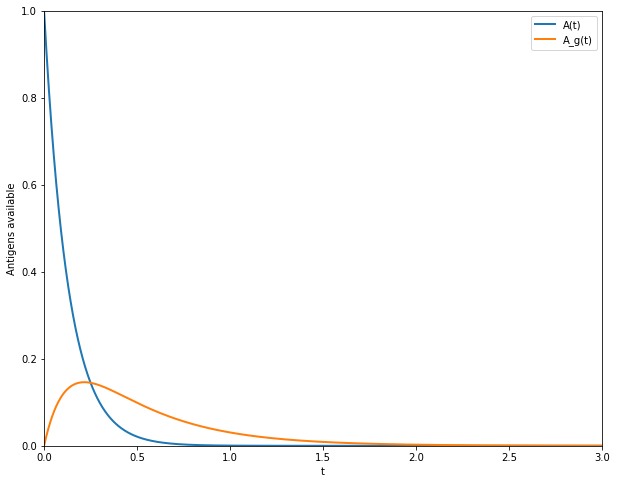

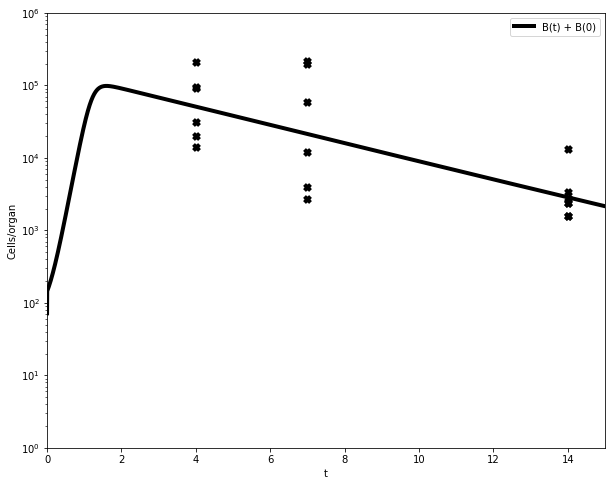

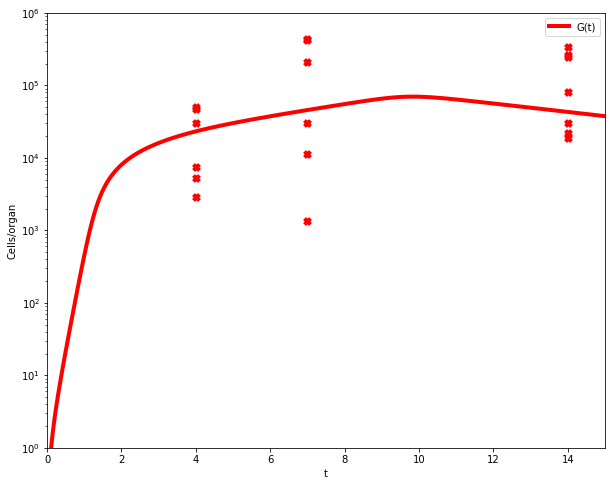

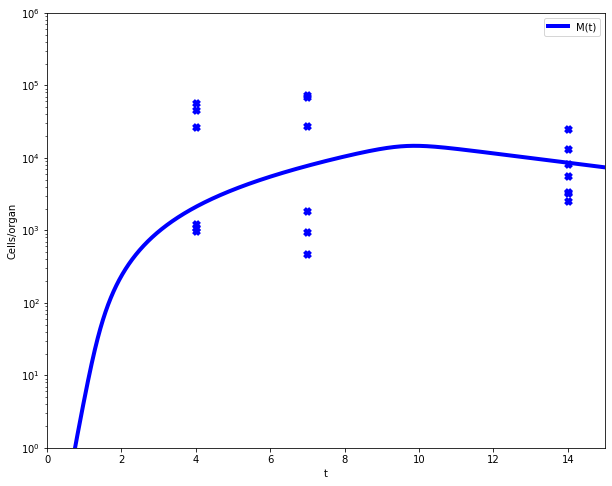

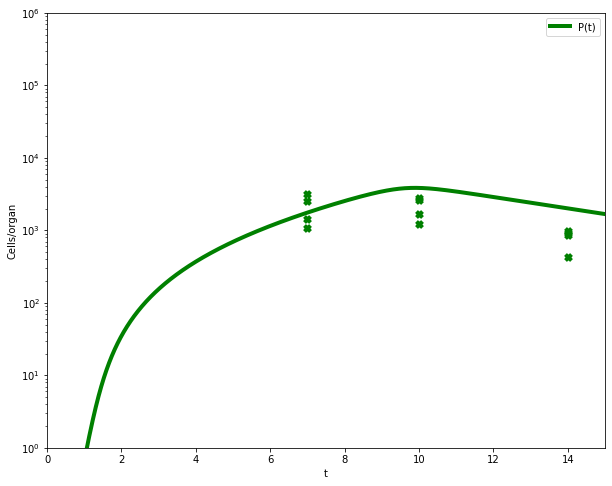

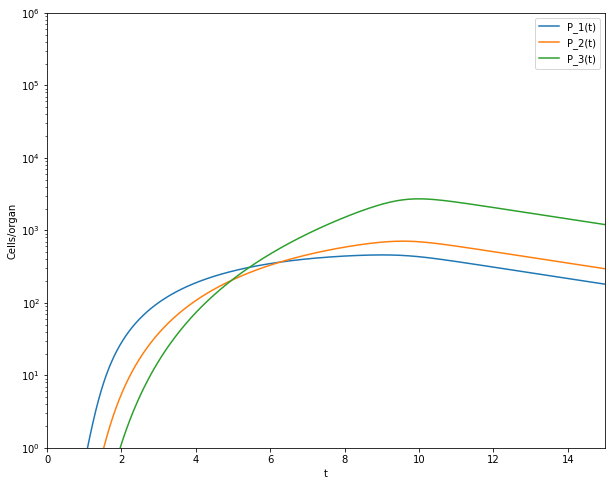

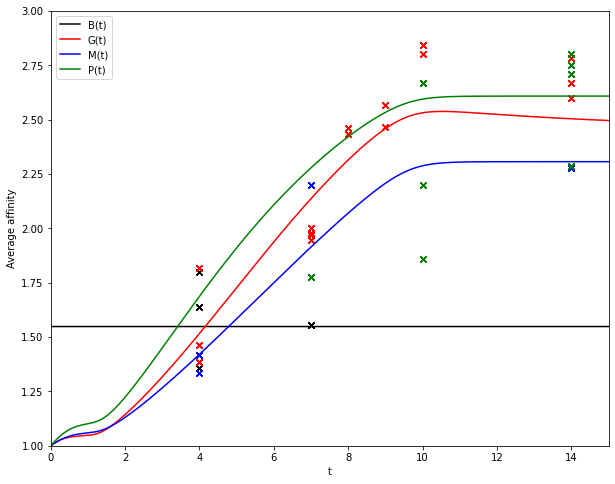

In [24]:
# Call the function to run the model so we can graph
print(v)
print(NLL(v))

# Graph of antigens available
fig1 = plt.figure()
fig1.set_size_inches(10,8)

plt.plot(tarr, Aarr, label = "A(t)", linewidth = 2)
plt.plot(tarr, A_garr, label = "A_g(t)", linewidth = 2)

plt.xlabel("t")
plt.ylabel("Antigens available")

plt.axis([t0, 3, 0, 1])

plt.legend()
plt.show()

#Plasmablasts graph

fig2 = plt.figure()
fig2.set_size_inches(10,8)

plt.plot(tarr, Barr, linewidth = 4, label = "B(t) + B(0)", color = 'black')
plt.scatter(Stimes, Spb, linewidth = 4, marker = 'x', color = 'black')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# GC B cells graph

fig3 = plt.figure()
fig3.set_size_inches(10,8)

plt.plot(tarr, Gtotarr, linewidth = 4, label = "G(t)", color = 'red')
plt.scatter(Stimes, Sgc, linewidth = 4, marker = 'x', color = 'red')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# MCB cells graph

fig4 = plt.figure()
fig4.set_size_inches(10,8)

plt.plot(tarr, Mtotarr, linewidth = 4, label = "M(t)", color = 'blue')
plt.scatter(Stimes, Smc, linewidth = 4, marker = 'x', color = 'blue')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Plasma cells graph

fig5 = plt.figure()
fig5.set_size_inches(10,8)

plt.plot(tarr, Ptotarr, linewidth = 4, label = "P(t)", color = 'green')
plt.scatter(Stimes2, Spc, linewidth = 4, marker = 'x', color = 'green')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Graph of GC B cell affinities 

fig6 = plt.figure()
fig6.set_size_inches(10,8)


plt.plot(tarr, Parr[1], label = "P_1(t)")
plt.plot(tarr, Parr[2], label = "P_2(t)")
plt.plot(tarr, Parr[3], label = "P_3(t)")
plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show

# Average affinities
fig7 = plt.figure()
fig7.set_size_inches(10,8)

plt.plot(tarr, calcAA()[0], label = "B(t)", color = 'black')
plt.scatter(Sapbt, Sapb, marker = 'x', color = 'black')
plt.plot(tarr, calcAA()[1], label = "G(t)", color = 'red')
plt.scatter(Sagct, Sagc, marker = 'x', color = 'red')
plt.plot(tarr, calcAA()[2], label = "M(t)", color = 'blue')
plt.scatter(Samct, Samc, marker = 'x', color = 'blue')
plt.plot(tarr, calcAA()[3], label = "P(t)", color = 'green')
plt.scatter(Sapct, Sapc, marker = 'x', color = 'green')


plt.xlabel("t")
plt.ylabel("Average affinity")
plt.axis([t0, tF, 1.0, 3.0])

plt.legend()
plt.show()

#### Here, we start fitting variables to the data using gradient descent

It is currently set to use SSR for this. This does not seem to be a good function to use for fitting the graph, as fits with less SSR don't look as good as the init fit.

In [23]:
learningRate = .1

def grad(v):
    nll1 = NLL(v)
    
    nlllist.append(nll1)
    print(nll1)
    
    grad = tuple(())
    
    for i in range(0, len(v)):
        if(vNames[i] not in vNames):
            grad += tuple((0.0,))
            continue
        
        dV = .01 * 10 ** (int(log(v[i], 10))) 
        v2 = v[0:i] + tuple((v[i] + dV, )) + v[i+1:]
        dnll = NLL(v2) - nll1
        
        print('  dV of ', dV, ' on ', vNames[i], ' got nll of', dnll + nll1, ' for a dnll ', dnll)
        
        grad += tuple((dnll/dV, ))
    
    print('  grad =', grad)
    
    return grad
    
def deltaV(grad, v):
    gMax = max(np.absolute(grad))
    gMin = min(np.absolute(grad))
        
    deltaV = tuple(())
    for i in range(0, len(v)):
        if (grad[i] == 0.0): deltaV += tuple((0.0,))
        else: deltaV += tuple(((-1 * (grad[i]/abs(grad[i])) * (abs(grad[i]/gMax)) * v[i] * learningRate),))
    
    return deltaV
        
              
def gradDescent(v):
    strikes = 0 # just like baseball, if it misses 3 times we stop
    for i in range (1, 100):
        nllOld = NLL(v)
        
        print(i)
        print('v = ', v)
        
        dV = deltaV(grad(v), v)
        print('dV = ', dV)
        
        newV = tuple(())
        
        for j in range(0, len(v)):
            newV += tuple((v[j] + dV[j], ))
        
        nllNew = NLL(newV)
        
        if(nllNew > nllOld): 
            if(strikes == 0): goodV = v
            strikes += 1
            if(strikes >= 3):
                return goodV
        else: 
            strikes = 0
            
        v = newV
    
    return v

nlllist = list((NLL(v),))
v = gradDescent(v)

print(nlllist)

1
v =  (71.63707635429844, 0.08880205307601731, 0.20163423104856087, 0.1406712718515763, 0.14848556439026647, 0.1808401022604593, 0.25752987161035007, 7.276666445646036, 9.289485009186102e-05, 1.3769828275516603e-11, 5.773477050721754, 2.4799302155514957, 1.9251641085744973, 12265000.0, 6.445835386171103, 0.2762954144238309, 0.4173407077560404, 0.6245891618508299)
-51.53319229012443
  dV of  0.1  on  B0  got nll of -51.533988396599156  for a dnll  -0.0007961064747235014
  dV of  0.001  on  d_BG  got nll of -51.52942290047045  for a dnll  0.0037693896539821026
  dV of  0.01  on  delta_B  got nll of -51.44855405544709  for a dnll  0.08463823467734244
  dV of  0.01  on  delta_G  got nll of -51.49897174792514  for a dnll  0.034220542199292936
  dV of  0.01  on  delta_M  got nll of -51.57928646317747  for a dnll  -0.04609417305303509
  dV of  0.01  on  delta_P  got nll of -51.58437302664595  for a dnll  -0.051180736521516224
  dV of  0.01  on  d_G  got nll of -51.551741956988494  for a dnll

4
v =  (71.63707635450179, 0.08880205296003543, 0.20163423044658865, 0.1406712716776367, 0.14848556463175122, 0.18084010258747224, 0.25752987177757086, 7.2766664465677175, 9.289499449942795e-05, 1.4995342992037582e-11, 5.7734770519738605, 2.4799302153812612, 1.9251641089846556, 12265000.0, 6.445835386457105, 0.2762954092800137, 0.41734070624923864, 0.6245891612512614)
-51.53319471382221
  dV of  0.1  on  B0  got nll of -51.53418185934149  for a dnll  -0.0009871455192751455
  dV of  0.001  on  d_BG  got nll of -51.531384895795384  for a dnll  0.001809818026828225
  dV of  0.01  on  delta_B  got nll of -51.452633412795436  for a dnll  0.08056130102677628
  dV of  0.01  on  delta_G  got nll of -51.47839841407266  for a dnll  0.05479629974955458
  dV of  0.01  on  delta_M  got nll of -51.577358220134414  for a dnll  -0.04416350631220212
  dV of  0.01  on  delta_P  got nll of -51.58413231939048  for a dnll  -0.0509376055682651
  dV of  0.01  on  d_G  got nll of -51.547068356408886  for a dn

7
v =  (71.63707635457381, 0.08880205292674784, 0.2016342302484464, 0.14067127161070198, 0.14848556471137392, 0.18084010269635933, 0.2575298718296002, 7.276666446874619, 9.289504004580632e-05, 1.3360850605905484e-11, 5.773477052371571, 2.479930215273892, 1.9251641091169602, 12265000.0, 6.445835386583284, 0.27629540760994936, 0.4173407057490854, 0.6245891610491955)
-51.53179605303954
  dV of  0.1  on  B0  got nll of -51.53252491815249  for a dnll  -0.0007288651129471191
  dV of  0.001  on  d_BG  got nll of -51.52734012113574  for a dnll  0.0044559319038057765
  dV of  0.01  on  delta_B  got nll of -51.44575633874531  for a dnll  0.08603971429423041
  dV of  0.01  on  delta_G  got nll of -51.504798938609554  for a dnll  0.026997114429988756
  dV of  0.01  on  delta_M  got nll of -51.57856507274904  for a dnll  -0.04676901970950098
  dV of  0.01  on  delta_P  got nll of -51.58305922394008  for a dnll  -0.051263170900540445
  dV of  0.01  on  d_G  got nll of -51.551986634336956  for a dnll

10
v =  (71.63707635463942, 0.0888020528861751, 0.2016342300481465, 0.14067127155673675, 0.14848556479168595, 0.18084010280468518, 0.2575298718864753, 7.276666447179944, 9.289508892733563e-05, 1.4549966309831071e-11, 5.773477052794213, 2.4799302152373954, 1.9251641092546241, 12265000.0, 6.445835386665396, 0.27629540588878243, 0.4173407052494472, 0.6245891608516249)
-51.53387013363805
  dV of  0.1  on  B0  got nll of -51.534789673100946  for a dnll  -0.0009195394628989106
  dV of  0.001  on  d_BG  got nll of -51.53136452399163  for a dnll  0.002505609646419771
  dV of  0.01  on  delta_B  got nll of -51.45184446959327  for a dnll  0.08202566404477807
  dV of  0.01  on  delta_G  got nll of -51.48637324851272  for a dnll  0.04749688512532657
  dV of  0.01  on  delta_M  got nll of -51.57871952564027  for a dnll  -0.044849392002220156
  dV of  0.01  on  delta_P  got nll of -51.58489501017688  for a dnll  -0.051024876538832586
  dV of  0.01  on  d_G  got nll of -51.549404027534464  for a dnll

13
v =  (71.63707635471329, 0.08880205285173218, 0.20163422984433083, 0.14067127148829298, 0.14848556487357648, 0.18084010291662958, 0.25752987194011717, 7.276666447495461, 9.289513584970792e-05, 1.2964019982059485e-11, 5.7734770532038375, 2.4799302151292495, 1.925164109390796, 12265000.0, 6.4458353867939, 0.2762954041700436, 0.4173407047351495, 0.6245891606439712)
-51.52968514503573
  dV of  0.1  on  B0  got nll of -51.53034684899481  for a dnll  -0.0006617039590821605
  dV of  0.001  on  d_BG  got nll of -51.524545793542245  for a dnll  0.005139351493482991
  dV of  0.01  on  delta_B  got nll of -51.442267454249816  for a dnll  0.08741769078591233
  dV of  0.01  on  delta_G  got nll of -51.50988584195167  for a dnll  0.01979930308405642
  dV of  0.01  on  delta_M  got nll of -51.577125431707856  for a dnll  -0.04744028667212774
  dV of  0.01  on  delta_P  got nll of -51.581029289593374  for a dnll  -0.05134414455764613
  dV of  0.01  on  d_G  got nll of -51.551509587619336  for a dnl

16
v =  (71.63707635477877, 0.08880205281134389, 0.201634229644632, 0.14067127143436567, 0.14848556495365023, 0.18084010302464773, 0.2575298719967853, 7.27666644779992, 9.289518456087281e-05, 1.4117817760462779e-11, 5.773477053625036, 2.4799302150921267, 1.9251641095280199, 12265000.0, 6.445835386876175, 0.2762954024543153, 0.41734070423696695, 0.6245891604469384)
-51.53380380520004
  dV of  0.1  on  B0  got nll of -51.534655853842295  for a dnll  -0.0008520486422582962
  dV of  0.001  on  d_BG  got nll of -51.530605650194005  for a dnll  0.003198155006032266
  dV of  0.01  on  delta_B  got nll of -51.450336574223385  for a dnll  0.08346723097665176
  dV of  0.01  on  delta_G  got nll of -51.49357967659104  for a dnll  0.04022412860899749
  dV of  0.01  on  delta_M  got nll of -51.57933525746323  for a dnll  -0.045531452263190886
  dV of  0.01  on  delta_P  got nll of -51.58491427470538  for a dnll  -0.051110469505346146
  dV of  0.01  on  d_G  got nll of -51.550991017366854  for a dnl

19
v =  (71.63707635501022, 0.08880205269064459, 0.20163422898133196, 0.14067127122869738, 0.1484855652198917, 0.1808401033867289, 0.2575298721766591, 7.276666448820438, 9.28953407253453e-05, 1.2578975624572336e-11, 5.773477054983266, 2.4799302148311226, 1.9251641099758199, 12265000.0, 6.445835387238105, 0.27629539682059234, 0.41734070257063255, 0.6245891597794716)
-51.52687056598808
  dV of  0.1  on  B0  got nll of -51.52746527016707  for a dnll  -0.0005947041789937657
  dV of  0.001  on  d_BG  got nll of -51.52105111455846  for a dnll  0.0058194514296161515
  dV of  0.01  on  delta_B  got nll of -51.43809571135084  for a dnll  0.08877485463723644
  dV of  0.01  on  delta_G  got nll of -51.5142417728362  for a dnll  0.012628793151876039
  dV of  0.01  on  delta_M  got nll of -51.574978039434626  for a dnll  -0.04810747344654942
  dV of  0.01  on  delta_P  got nll of -51.57829391796949  for a dnll  -0.05142335198141268
  dV of  0.01  on  d_G  got nll of -51.55032227292516  for a dnll  

22
v =  (71.63707635538016, 0.08880205248398164, 0.201634227894583, 0.1406712709093706, 0.14848556565586987, 0.18084010397770944, 0.25752987247688197, 7.276666450486122, 9.289560023557298e-05, 1.3698504455159274e-11, 5.7734770572350635, 2.47993021449601, 1.9251641107145383, 12265000.0, 6.445835387772652, 0.2762953875479538, 0.41734069984825595, 0.6245891586945477)
-51.53300753471417
  dV of  0.1  on  B0  got nll of -51.53379233467224  for a dnll  -0.0007847999580690157
  dV of  0.001  on  d_BG  got nll of -51.52912039576874  for a dnll  0.0038871389454300243
  dV of  0.01  on  delta_B  got nll of -51.4481174076284  for a dnll  0.08489012708577093
  dV of  0.01  on  delta_G  got nll of -51.50002681274482  for a dnll  0.03298072196935209
  dV of  0.01  on  delta_M  got nll of -51.57921643324876  for a dnll  -0.046208898534587206
  dV of  0.01  on  delta_P  got nll of -51.58420142675489  for a dnll  -0.05119389204071467
  dV of  0.01  on  d_G  got nll of -51.5518418312178  for a dnll  -0.

25
v =  (71.63707635551758, 0.0888020524040912, 0.20163422748487614, 0.14067127079290487, 0.14848556582018263, 0.18084010420000918, 0.25752987259129834, 7.276666451112685, 9.289569888135421e-05, 1.491767135166845e-11, 5.7734770580898624, 2.479930214390067, 1.925164110994161, 12265000.0, 6.445835387961226, 0.2762953840427321, 0.4173406988236719, 0.62458915828747)
-51.5333678217651
  dV of  0.1  on  B0  got nll of -51.53434358655187  for a dnll  -0.0009757647867729702
  dV of  0.001  on  d_BG  got nll of -51.531438629591975  for a dnll  0.0019291921731223738
  dV of  0.01  on  delta_B  got nll of -51.452544127608405  for a dnll  0.08082369415669177
  dV of  0.01  on  delta_G  got nll of -51.47982471141083  for a dnll  0.053543110354269174
  dV of  0.01  on  delta_M  got nll of -51.57764802270222  for a dnll  -0.04428020093712348
  dV of  0.01  on  delta_P  got nll of -51.584319462298765  for a dnll  -0.050951640533668296
  dV of  0.01  on  d_G  got nll of -51.547529376872035  for a dnll 

28
v =  (71.63707635558596, 0.08880205237278022, 0.20163422729731453, 0.140671270729168, 0.14848556589554773, 0.18084010430311656, 0.257529872640432, 7.276666451403301, 9.28957418968614e-05, 1.3291645174336589e-11, 5.773477058465615, 2.4799302142864468, 1.9251641111192426, 12265000.0, 6.4458353880820605, 0.2762953824629345, 0.41734069835011295, 0.6245891580960327)
-51.53148758882742
  dV of  0.1  on  B0  got nll of -51.53220514850881  for a dnll  -0.0007175596813908669
  dV of  0.001  on  d_BG  got nll of -51.52691441355577  for a dnll  0.004573175271644914
  dV of  0.01  on  delta_B  got nll of -51.44520044022235  for a dnll  0.08628714860506648
  dV of  0.01  on  delta_G  got nll of -51.505726150797756  for a dnll  0.025761438029661576
  dV of  0.01  on  delta_M  got nll of -51.57837079890459  for a dnll  -0.046883210077169224
  dV of  0.01  on  delta_P  got nll of -51.58276371585842  for a dnll  -0.05127612703100226
  dV of  0.01  on  d_G  got nll of -51.55196151229882  for a dnll  

31
v =  (71.63707635564792, 0.08880205233422904, 0.2016342271076844, 0.14067127067836988, 0.14848556597156864, 0.18084010440562334, 0.25752987269437017, 7.27666645169223, 9.289578821714327e-05, 1.4474601594852545e-11, 5.773477058866048, 2.4799302142533888, 1.9251641112496147, 12265000.0, 6.445835388158961, 0.27629538083290445, 0.4173406978772686, 0.6245891579091524)
-51.53391501951242
  dV of  0.1  on  B0  got nll of -51.53482319593385  for a dnll  -0.0009081764214329269
  dV of  0.001  on  d_BG  got nll of -51.53129059013635  for a dnll  0.00262442937606977
  dV of  0.01  on  delta_B  got nll of -51.45163096634744  for a dnll  0.0822840531649831
  dV of  0.01  on  delta_G  got nll of -51.48766676863285  for a dnll  0.04624825087957163
  dV of  0.01  on  delta_M  got nll of -51.578880462217654  for a dnll  -0.04496544270523373
  dV of  0.01  on  delta_P  got nll of -51.58495365092705  for a dnll  -0.05103863141462739
  dV of  0.01  on  d_G  got nll of -51.54973561564023  for a dnll  -0

34
v =  (71.63707635572776, 0.08880205229652197, 0.20163422688649488, 0.14067127060476353, 0.1484855660604164, 0.18084010452700625, 0.25752987275279265, 7.276666452034353, 9.289583925024138e-05, 1.2896870021013617e-11, 5.773477059311394, 2.479930214139621, 1.9251641113975144, 12265000.0, 6.445835388296375, 0.27629537896629575, 0.41734069731947837, 0.62458915768415)
-51.52925493856823
  dV of  0.1  on  B0  got nll of -51.52990535802387  for a dnll  -0.0006504194556384846
  dV of  0.001  on  d_BG  got nll of -51.52399889866895  for a dnll  0.005256039899279585
  dV of  0.01  on  delta_B  got nll of -51.44159362399695  for a dnll  0.08766131457127813
  dV of  0.01  on  delta_G  got nll of -51.51068674936751  for a dnll  0.018568189200721008
  dV of  0.01  on  delta_M  got nll of -51.576808757255336  for a dnll  -0.047553818687106286
  dV of  0.01  on  delta_P  got nll of -51.58061176310942  for a dnll  -0.05135682454118751
  dV of  0.01  on  d_G  got nll of -51.55136154591251  for a dnll 

37
v =  (71.63707635580063, 0.08880205225212448, 0.20163422666530223, 0.14067127054438572, 0.1484855661491025, 0.18084010464671488, 0.2575298728153565, 7.276666452371767, 9.289589304227442e-05, 1.4044691452883829e-11, 5.7734770597767495, 2.4799302140951656, 1.9251641115492517, 12265000.0, 6.445835388389836, 0.2762953770677061, 0.41734069676744967, 0.6245891574656184)
-51.53372224856338
  dV of  0.1  on  B0  got nll of -51.53456295766293  for a dnll  -0.0008407090995490307
  dV of  0.001  on  d_BG  got nll of -51.53040584119907  for a dnll  0.0033164073643092706
  dV of  0.01  on  delta_B  got nll of -51.450000426203076  for a dnll  0.08372182236030312
  dV of  0.01  on  delta_G  got nll of -51.49474208792138  for a dnll  0.03898016064199794
  dV of  0.01  on  delta_M  got nll of -51.57936907260917  for a dnll  -0.04564682404578946
  dV of  0.01  on  delta_P  got nll of -51.5848461736132  for a dnll  -0.051123925049822105
  dV of  0.01  on  d_G  got nll of -51.551194987614394  for a dnl

40
v =  (71.63707635649361, 0.08880205187933461, 0.2016342246573326, 0.14067126993664125, 0.14848556695474716, 0.18084010574075168, 0.2575298733645024, 7.276666455455333, 9.28963686002738e-05, 1.2513820084519491e-11, 5.773477063908819, 2.479930213383897, 1.925164112908411, 12265000.0, 6.445835389437954, 0.2762953599797832, 0.41734069173003807, 0.6245891554525228)
-51.526322639806736
  dV of  0.1  on  B0  got nll of -51.52690620812989  for a dnll  -0.0005835683231509847
  dV of  0.001  on  d_BG  got nll of -51.52038738182158  for a dnll  0.005935257985157705
  dV of  0.01  on  delta_B  got nll of -51.43730393521467  for a dnll  0.08901870459206407
  dV of  0.01  on  delta_G  got nll of -51.5149176044208  for a dnll  0.01140503538593407
  dV of  0.01  on  delta_M  got nll of -51.57454218854535  for a dnll  -0.048219548738615
  dV of  0.01  on  delta_P  got nll of -51.577757880557286  for a dnll  -0.05143524075054984
  dV of  0.01  on  d_G  got nll of -51.55005601469078  for a dnll  -0.02

43
v =  (71.63707635664302, 0.08880205179325186, 0.20163422421338573, 0.14067126980952166, 0.14848556713278377, 0.1808401059817223, 0.2575298734881997, 7.276666456134536, 9.289647525975149e-05, 1.3627550072041727e-11, 5.773477064833367, 2.479930213264042, 1.9251641132110517, 12265000.0, 6.44583538964565, 0.27629535618416545, 0.41734069061956247, 0.6245891550110368)
-51.53280222975383
  dV of  0.1  on  B0  got nll of -51.533575775987714  for a dnll  -0.0007735462338871457
  dV of  0.001  on  d_BG  got nll of -51.52879756432168  for a dnll  0.004004665432148613
  dV of  0.01  on  delta_B  got nll of -51.447659327338215  for a dnll  0.08514290241561184
  dV of  0.01  on  delta_G  got nll of -51.50105945669014  for a dnll  0.03174277306368367
  dV of  0.01  on  delta_M  got nll of -51.57912543128445  for a dnll  -0.04632320153062608
  dV of  0.01  on  delta_P  got nll of -51.584009027996416  for a dnll  -0.051206798242589
  dV of  0.01  on  d_G  got nll of -51.5519212134019  for a dnll  -0

46
v =  (71.63707635674977, 0.08880205173016333, 0.20163422389312657, 0.14067126971978164, 0.14848556726118847, 0.18084010615530116, 0.2575298735780461, 7.276666456623789, 9.289655260250426e-05, 1.484040202845344e-11, 5.773477065503227, 2.4799302131879353, 1.9251641134299162, 12265000.0, 6.445835389789014, 0.27629535344139156, 0.4173406898193418, 0.6245891546935171)
-51.53351953554056
  dV of  0.1  on  B0  got nll of -51.53448398196559  for a dnll  -0.0009644464250300189
  dV of  0.001  on  d_BG  got nll of -51.53147121767154  for a dnll  0.0020483178690255954
  dV of  0.01  on  delta_B  got nll of -51.45243227602475  for a dnll  0.08108725951581164
  dV of  0.01  on  delta_G  got nll of -51.48122752753193  for a dnll  0.052292008008635094
  dV of  0.01  on  delta_M  got nll of -51.577915946363674  for a dnll  -0.04439641082311141
  dV of  0.01  on  delta_P  got nll of -51.58448491910474  for a dnll  -0.05096538356417568
  dV of  0.01  on  d_G  got nll of -51.547969111678555  for a dnl

49
v =  (71.63707635681654, 0.08880205169973483, 0.2016342237103043, 0.1406712696574957, 0.1484855673346382, 0.1808401062558072, 0.2575298736258881, 7.276666456907078, 9.289659447250856e-05, 1.3222798207352016e-11, 5.773477065869057, 2.479930213086106, 1.9251641135517283, 12265000.0, 6.445835389907501, 0.27629535190212123, 0.4173406893577378, 0.624589154506865)
-51.531159075876545
  dV of  0.1  on  B0  got nll of -51.5318653931558  for a dnll  -0.0007063172792527439
  dV of  0.001  on  d_BG  got nll of -51.52646890605466  for a dnll  0.004690169821884638
  dV of  0.01  on  delta_B  got nll of -51.44462328426904  for a dnll  0.08653579160750269
  dV of  0.01  on  delta_G  got nll of -51.50663122019752  for a dnll  0.02452785567902538
  dV of  0.01  on  delta_M  got nll of -51.57815599016301  for a dnll  -0.04699691428646702
  dV of  0.01  on  delta_P  got nll of -51.5824478690199  for a dnll  -0.05128879314335677
  dV of  0.01  on  d_G  got nll of -51.55191645370026  for a dnll  -0.0207

52
v =  (71.63707635687638, 0.08880205166237827, 0.20163422352692842, 0.14067126960854454, 0.14848556740813812, 0.1808401063548971, 0.25752987367810193, 7.276666457186383, 9.289663927828362e-05, 1.4399627247806346e-11, 5.7734770662563735, 2.4799302130550087, 1.9251641136777962, 12265000.0, 6.445835389981456, 0.27629535032563407, 0.41734068890062276, 0.6245891543262589)
-51.533938876049874
  dV of  0.1  on  B0  got nll of -51.53483575279118  for a dnll  -0.0008968767413080059
  dV of  0.001  on  d_BG  got nll of -51.531195877604844  for a dnll  0.002742998445029343
  dV of  0.01  on  delta_B  got nll of -51.451395226323044  for a dnll  0.08254364972682993
  dV of  0.01  on  delta_G  got nll of -51.48893715253233  for a dnll  0.045001723517543724
  dV of  0.01  on  delta_M  got nll of -51.57901987918818  for a dnll  -0.045081003138307096
  dV of  0.01  on  delta_P  got nll of -51.584990967556664  for a dnll  -0.05105209150679002
  dV of  0.01  on  d_G  got nll of -51.55004628823504  for 

55
v =  (71.63707635696498, 0.08880205161987301, 0.20163422328016034, 0.14067126952732242, 0.1484855675072292, 0.18084010649017826, 0.25752987374355835, 7.276666457567686, 9.289669636096581e-05, 1.2830067877795454e-11, 5.773477066754291, 2.479930212932873, 1.92516411384296, 12265000.0, 6.44583539013204, 0.2762953482413532, 0.41734068827879467, 0.6245891540757079)
-51.52880504869579
  dV of  0.1  on  B0  got nll of -51.52944424788397  for a dnll  -0.0006391991881855574
  dV of  0.001  on  d_BG  got nll of -51.523432571960754  for a dnll  0.00537247673503316
  dV of  0.01  on  delta_B  got nll of -51.44089885956704  for a dnll  0.08790618912874493
  dV of  0.01  on  delta_G  got nll of -51.51146585482992  for a dnll  0.017339193865865354
  dV of  0.01  on  delta_M  got nll of -51.57647190638271  for a dnll  -0.04766685768692014
  dV of  0.01  on  delta_P  got nll of -51.58017425946841  for a dnll  -0.05136921077262002
  dV of  0.01  on  d_G  got nll of -51.551193939465634  for a dnll  -0

58
v =  (71.6370763570513, 0.08880205156818571, 0.2016342230199493, 0.14067126945525427, 0.1484855676115514, 0.18084010663110914, 0.25752987381683057, 7.276666457964923, 9.289675938476969e-05, 1.397194391891925e-11, 5.773477067299867, 2.4799302128752188, 1.9251641140210591, 12265000.0, 6.445835390245708, 0.2762953460107264, 0.41734068762901383, 0.6245891538181528)
-51.533620050701884
  dV of  0.1  on  B0  got nll of -51.53444948605534  for a dnll  -0.000829435353452368
  dV of  0.001  on  d_BG  got nll of -51.530185647567365  for a dnll  0.0034344031345199255
  dV of  0.01  on  delta_B  got nll of -51.44964234891792  for a dnll  0.08397770178396513
  dV of  0.01  on  delta_G  got nll of -51.4958816995789  for a dnll  0.037738351122982294
  dV of  0.01  on  delta_M  got nll of -51.5793817416709  for a dnll  -0.045761690969015945
  dV of  0.01  on  delta_P  got nll of -51.58475712776938  for a dnll  -0.051137077067494374
  dV of  0.01  on  d_G  got nll of -51.55137844345833  for a dnll  

61
v =  (71.63707635753701, 0.08880205129812001, 0.20163422159566594, 0.1406712690354902, 0.14848556818276698, 0.18084010740556652, 0.25752987420989076, 7.2766664601477995, 9.28970988685513e-05, 1.5215446927703063e-11, 5.773477070246463, 2.4799302124300193, 1.9251641149879308, 12265000.0, 6.445835390952914, 0.27629533386439625, 0.4173406840613054, 0.6245891523959791)
-51.53260977347429
  dV of  0.1  on  B0  got nll of -51.53363048193202  for a dnll  -0.0010207084577302794
  dV of  0.001  on  d_BG  got nll of -51.53113957272197  for a dnll  0.0014702007523226257
  dV of  0.01  on  delta_B  got nll of -51.45273772023313  for a dnll  0.07987205324116076
  dV of  0.01  on  delta_G  got nll of -51.47425761308571  for a dnll  0.05835216038857993
  dV of  0.01  on  delta_M  got nll of -51.57643507171031  for a dnll  -0.04382529823601544
  dV of  0.01  on  delta_P  got nll of -51.58350110106116  for a dnll  -0.050891327586867874
  dV of  0.01  on  d_G  got nll of -51.54568310866347  for a dnll

64
v =  (71.63707635764573, 0.08880205124492876, 0.20163422129093703, 0.14067126893659368, 0.14848556830510845, 0.18084010757243632, 0.2575298742911646, 7.276666460618146, 9.289716963769129e-05, 1.3556963212583426e-11, 5.773477070863345, 2.4799302122864195, 1.9251641151922672, 12265000.0, 6.445835391134322, 0.27629533128728034, 0.417340683294094, 0.6245891520872923)
-51.532574531665986
  dV of  0.1  on  B0  got nll of -51.53333675628319  for a dnll  -0.0007622246172047653
  dV of  0.001  on  d_BG  got nll of -51.52845225164613  for a dnll  0.004122280019856817
  dV of  0.01  on  delta_B  got nll of -51.447181761714646  for a dnll  0.0853927699513406
  dV of  0.01  on  delta_G  got nll of -51.50207048732214  for a dnll  0.030504044343842907
  dV of  0.01  on  delta_M  got nll of -51.57901237222613  for a dnll  -0.046437840560145105
  dV of  0.01  on  delta_P  got nll of -51.58379448027638  for a dnll  -0.05121994861039525
  dV of  0.01  on  d_G  got nll of -51.55197761720582  for a dnll

67
v =  (71.63707635773477, 0.0888020511915626, 0.20163422102241563, 0.14067126886230144, 0.14848556841274554, 0.18084010771783815, 0.2575298743667962, 7.276666461027988, 9.289723465993249e-05, 1.476353293850335e-11, 5.773477071426245, 2.4799302122275075, 1.9251641153759946, 12265000.0, 6.445835391251548, 0.27629532898550957, 0.4173406826236359, 0.6245891518215655)
-51.53364827571838
  dV of  0.1  on  B0  got nll of -51.53460133936183  for a dnll  -0.0009530636434504913
  dV of  0.001  on  d_BG  got nll of -51.53148075398492  for a dnll  0.0021675217334546915
  dV of  0.01  on  delta_B  got nll of -51.45230026117349  for a dnll  0.08134801454488638
  dV of  0.01  on  delta_G  got nll of -51.48260806270258  for a dnll  0.051040213015795644
  dV of  0.01  on  delta_M  got nll of -51.57816121129193  for a dnll  -0.044512935573550294
  dV of  0.01  on  delta_P  got nll of -51.58462763145363  for a dnll  -0.05097935573525092
  dV of  0.01  on  d_G  got nll of -51.54838530210634  for a dnll 

70
v =  (71.63707635780143, 0.08880205116117455, 0.20163422083985205, 0.14067126880012623, 0.14848556848608002, 0.1808401078181854, 0.2575298744145769, 7.276666461310833, 9.289727645408396e-05, 1.3154307848206485e-11, 5.773477071791434, 2.4799302121259665, 1.9251641154975878, 12265000.0, 6.445835391369936, 0.27629532744855284, 0.41734068216274084, 0.6245891516352088)
-51.530808450649516
  dV of  0.1  on  B0  got nll of -51.53150346163035  for a dnll  -0.0006950109808343541
  dV of  0.001  on  d_BG  got nll of -51.52600120811033  for a dnll  0.004807242539186518
  dV of  0.01  on  delta_B  got nll of -51.44402679411823  for a dnll  0.08678165653128644
  dV of  0.01  on  delta_G  got nll of -51.50751487335236  for a dnll  0.02329357729715298
  dV of  0.01  on  delta_M  got nll of -51.57791937980623  for a dnll  -0.047110929156716
  dV of  0.01  on  delta_P  got nll of -51.58211013799466  for a dnll  -0.05130168734514484
  dV of  0.01  on  d_G  got nll of -51.55184872036139  for a dnll  -

73
v =  (71.63707635786052, 0.08880205112426656, 0.20163422065876344, 0.1406712687518355, 0.14848556855865333, 0.1808401079160216, 0.2575298744661557, 7.276666461586608, 9.289732069336572e-05, 1.4325041246696862e-11, 5.7734770721738595, 2.4799302120954994, 1.9251641156220545, 12265000.0, 6.445835391442932, 0.2762953258917658, 0.4173406817113957, 0.6245891514569005)
-51.533939995944095
  dV of  0.1  on  B0  got nll of -51.53482550940966  for a dnll  -0.0008855134655618713
  dV of  0.001  on  d_BG  got nll of -51.531078352037  for a dnll  0.0028616439070958677
  dV of  0.01  on  delta_B  got nll of -51.45113952998405  for a dnll  0.08280046596004809
  dV of  0.01  on  delta_G  got nll of -51.49018547819476  for a dnll  0.04375451774933481
  dV of  0.01  on  delta_M  got nll of -51.57913686895155  for a dnll  -0.04519687300745545
  dV of  0.01  on  delta_P  got nll of -51.585005773595654  for a dnll  -0.05106577765155862
  dV of  0.01  on  d_G  got nll of -51.550333659232976  for a dnll  

76
v =  (71.63707635796239, 0.08880205107452886, 0.2016342203734275, 0.14067126865911328, 0.14848556867319745, 0.18084010807227055, 0.25752987454221316, 7.276666462027015, 9.289738690921154e-05, 1.2763611750806904e-11, 5.773477072751129, 2.4799302119606446, 1.9251641158132817, 12265000.0, 6.4458353916133255, 0.27629532347918245, 0.4173406809929696, 0.624589151167804)
-51.52833329400019
  dV of  0.1  on  B0  got nll of -51.52896121064239  for a dnll  -0.0006279166422018534
  dV of  0.001  on  d_BG  got nll of -51.522844306066816  for a dnll  0.005488987933375711
  dV of  0.01  on  delta_B  got nll of -51.44018495340353  for a dnll  0.08814834059666055
  dV of  0.01  on  delta_G  got nll of -51.51222375990048  for a dnll  0.016109534099712164
  dV of  0.01  on  delta_M  got nll of -51.57611349097084  for a dnll  -0.04778019697064906
  dV of  0.01  on  delta_P  got nll of -51.57971511277975  for a dnll  -0.05138181877956072
  dV of  0.01  on  d_G  got nll of -51.551003915793615  for a dnl

79
v =  (71.63707635807586, 0.08880205100804675, 0.2016342200341432, 0.14067126856337747, 0.1484855688092186, 0.18084010825622096, 0.25752987463719346, 7.276666462545515, 9.289746866922022e-05, 1.389957319662872e-11, 5.773477073459483, 2.479930211876378, 1.9251641160448671, 12265000.0, 6.44583539176771, 0.27629532057540734, 0.41734068014504205, 0.6245891508311519)
-51.53349541807508
  dV of  0.1  on  B0  got nll of -51.534313521085906  for a dnll  -0.0008181030108289633
  dV of  0.001  on  d_BG  got nll of -51.52994295530452  for a dnll  0.0035524627705569856
  dV of  0.01  on  delta_B  got nll of -51.44926445602799  for a dnll  0.08423096204708713
  dV of  0.01  on  delta_G  got nll of -51.496999448945175  for a dnll  0.03649596912990205
  dV of  0.01  on  delta_M  got nll of -51.57937225374549  for a dnll  -0.045876835670412675
  dV of  0.01  on  delta_P  got nll of -51.584645853062554  for a dnll  -0.051150434987476956
  dV of  0.01  on  d_G  got nll of -51.551538927648735  for a dn

82
v =  (71.6370763589172, 0.08880205054404551, 0.20163421757449898, 0.1406712678339938, 0.14848556979557695, 0.18084010959404034, 0.2575298753145751, 7.276666466316328, 9.289805371327153e-05, 1.5136635211128676e-11, 5.773477078539159, 2.479930211084327, 1.9251641177125758, 12265000.0, 6.4458353930058605, 0.2762952996128668, 0.41734067398253377, 0.6245891483732422)
-51.532846803246
  dV of  0.1  on  B0  got nll of -51.533856220442686  for a dnll  -0.0010094171966841259
  dV of  0.001  on  d_BG  got nll of -51.53125721223719  for a dnll  0.001589591008809066
  dV of  0.01  on  delta_B  got nll of -51.45270733443684  for a dnll  0.08013946880916478
  dV of  0.01  on  delta_G  got nll of -51.475747888852965  for a dnll  0.0570989143930376
  dV of  0.01  on  delta_M  got nll of -51.57678849040457  for a dnll  -0.043941687158564946
  dV of  0.01  on  delta_P  got nll of -51.58375190073198  for a dnll  -0.05090509748598038
  dV of  0.01  on  d_G  got nll of -51.5462091612178  for a dnll  -0.

85
v =  (71.63707635900528, 0.08880205050212141, 0.2016342173298977, 0.14067126775311226, 0.1484855698937822, 0.18084010972815578, 0.2575298753793473, 7.276666466694362, 9.289811017686046e-05, 1.348674197311565e-11, 5.773477079031831, 2.479930210961079, 1.925164117876093, 12265000.0, 6.445835393156677, 0.27629529754812165, 0.41734067336614616, 0.6245891481247736)
-51.53232716171763
  dV of  0.1  on  B0  got nll of -51.533078165428634  for a dnll  -0.0007510037110023404
  dV of  0.001  on  d_BG  got nll of -51.528087613229076  for a dnll  0.004239548488556011
  dV of  0.01  on  delta_B  got nll of -51.446682134581124  for a dnll  0.08564502713650768
  dV of  0.01  on  delta_G  got nll of -51.503058922793656  for a dnll  0.029268238923975787
  dV of  0.01  on  delta_M  got nll of -51.57887891797017  for a dnll  -0.0465517562525406
  dV of  0.01  on  delta_P  got nll of -51.583559815958694  for a dnll  -0.05123265424106194
  dV of  0.01  on  d_G  got nll of -51.552014661803184  for a dnll

88
v =  (71.637076359083, 0.08880205045497953, 0.20163421709444904, 0.14067126768868654, 0.1484855699881377, 0.18084010985553906, 0.2575298754458898, 7.276666467053424, 9.289816730954663e-05, 1.4687062008722943e-11, 5.773477079526255, 2.47993021091311, 1.9251641180373276, 12265000.0, 6.4458353932573065, 0.2762952955283833, 0.4173406727786632, 0.6245891478921641)
-51.5337562699099
  dV of  0.1  on  B0  got nll of -51.53469805314771  for a dnll  -0.0009417832378062485
  dV of  0.001  on  d_BG  got nll of -51.53146989569737  for a dnll  0.0022863742125309727
  dV of  0.01  on  delta_B  got nll of -51.45214507000732  for a dnll  0.08161119990258214
  dV of  0.01  on  delta_G  got nll of -51.48396488824696  for a dnll  0.04979138166294206
  dV of  0.01  on  delta_M  got nll of -51.578384993567454  for a dnll  -0.04462872365755288
  dV of  0.01  on  delta_P  got nll of -51.584749142035776  for a dnll  -0.050992872125874555
  dV of  0.01  on  d_G  got nll of -51.54878106922146  for a dnll  -0

91
v =  (71.63707635915094, 0.08880205042388739, 0.2016342169081545, 0.14067126762542925, 0.1484855700629531, 0.1808401099578939, 0.2575298754947049, 7.276666467341933, 9.289820996716356e-05, 1.3086172249772141e-11, 5.773477079898972, 2.479930210810523, 1.925164118161385, 12265000.0, 6.445835393377689, 0.2762952939598283, 0.41734067230849503, 0.6245891477021192)
-51.5304385712039
  dV of  0.1  on  B0  got nll of -51.53112237874653  for a dnll  -0.000683807542628756
  dV of  0.001  on  d_BG  got nll of -51.525514607251765  for a dnll  0.004923963952137456
  dV of  0.01  on  delta_B  got nll of -51.443408588400445  for a dnll  0.08702998280345753
  dV of  0.01  on  delta_G  got nll of -51.508376303191355  for a dnll  0.022062268012547293
  dV of  0.01  on  delta_M  got nll of -51.57766277938312  for a dnll  -0.04722420817921602
  dV of  0.01  on  delta_P  got nll of -51.581752700693  for a dnll  -0.05131412948909997
  dV of  0.01  on  d_G  got nll of -51.55176205655363  for a dnll  -0.02

94
v =  (71.63707635921067, 0.08880205038666324, 0.20163421672525744, 0.14067126757657472, 0.14848557013623873, 0.18084011005670075, 0.2575298755467736, 7.27666646762045, 9.289825460508521e-05, 1.4250841580001862e-11, 5.773477080284899, 2.4799302107793175, 1.9251641182870072, 12265000.0, 6.445835393451868, 0.2762952923879213, 0.41734067185267076, 0.6245891475220188)
-51.53392077159002
  dV of  0.1  on  B0  got nll of -51.53479502493879  for a dnll  -0.0008742533487691162
  dV of  0.001  on  d_BG  got nll of -51.53094083528215  for a dnll  0.0029799363078666374
  dV of  0.01  on  delta_B  got nll of -51.450861030383905  for a dnll  0.08305974120611381
  dV of  0.01  on  delta_G  got nll of -51.49141048007861  for a dnll  0.042510291511405285
  dV of  0.01  on  delta_M  got nll of -51.57923277388292  for a dnll  -0.045312002292902775
  dV of  0.01  on  delta_P  got nll of -51.58499977790301  for a dnll  -0.051079006312988895
  dV of  0.01  on  d_G  got nll of -51.55060101241369  for a dn

97
v =  (71.63707635933382, 0.08880205032531885, 0.20163421637795878, 0.14067126746535774, 0.14848557027560588, 0.1808401102466339, 0.2575298756398569, 7.276666468155812, 9.289833548261615e-05, 1.269749984778166e-11, 5.773477080989574, 2.4799302106239165, 1.925164118520084, 12265000.0, 6.445835393654206, 0.276295289448002, 0.41734067097906385, 0.6245891471709956)
-51.527842715219236
  dV of  0.1  on  B0  got nll of -51.528459454768864  for a dnll  -0.0006167395496277095
  dV of  0.001  on  d_BG  got nll of -51.52223757371581  for a dnll  0.005605141503423283
  dV of  0.01  on  delta_B  got nll of -51.439449676174604  for a dnll  0.08839303904463236
  dV of  0.01  on  delta_G  got nll of -51.51295981617119  for a dnll  0.014882899048046738
  dV of  0.01  on  delta_M  got nll of -51.57573550038873  for a dnll  -0.0478927851694948
  dV of  0.01  on  delta_P  got nll of -51.57923668086136  for a dnll  -0.051393965642120065
  dV of  0.01  on  d_G  got nll of -51.550795405170106  for a dnll 

[-51.53319229012443, -51.53319229012443, -51.53280294056425, -51.53280705180336, -51.53319471382221, -51.53234144445014, -51.533502903990225, -51.53179605303954, -51.53372791617805, -51.531171286077196, -51.53387013363805, -51.53046752465268, -51.533929934065554, -51.52968514503573, -51.53390769576551, -51.52882453125835, -51.53380380520004, -51.527886105866585, -51.53361868165936, -51.52687056598808, -51.533352973380204, -51.532586774689875, -51.53300753471417, -51.53301920131635, -51.53258075286372, -51.5333678217651, -51.5320739542267, -51.53363307329509, -51.53148758882742, -51.53381534607968, -51.53082204617107, -51.53391501951242, -51.53007770329053, -51.533932470918316, -51.52925493856823, -51.53386808141698, -51.5283541488098, -51.53372224856338, -51.52737582388232, -51.533495447924864, -51.526322639806736, -51.53318997407638, -51.53282476378223, -51.53280222975383, -51.53321393407627, -51.532334145677524, -51.53351953554056, -51.53178629211288, -51.53374197196392, -51.53115907

#### Here, we define a sum of square residuals function to evaluate each model

In [ ]:
def SSR(scatterTimes, scatterVals, valArr):
    j = 0
    ssr = 0.0
    for i in scatterTimes:
        actual = scatterVals[j]
        pred = valArr[int(i / dt)]
        sr = (actual - pred) * (actual - pred)
        ssr += sr
        #print(i, j, actual, pred, sr, ssr)
        j += 1
        
    return ssr

# 

In [ ]:
def SSRAll(v):
    global Stimes, Spb, tarr, Barr, Sgc, Gtotarr, Smc, Mtotarr, Stimes2, Spc, Ptotarr
    euler(v)
    ssrAll = 0.0
    ssrAll = SSR(Stimes, Spb, Barr)
    ssrAll += SSR(Stimes, Sgc, Gtotarr)
    ssrAll += SSR(Stimes, Smc, Mtotarr)
    ssrAll += SSR(Stimes2, Spc, Ptotarr)
    
    return ssrAll